# 2. Modelling

# 2.1 Robus PrincipalComponentAnalysis(rPCA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

from pyod.models.hbos import HBOS
from sklearn.ensemble import RandomForestClassifier

In [2]:
final_df = pd.read_csv("Final_DF.csv")

final_df['date'] = pd.to_datetime(final_df['date'])
final_df['time'] = pd.to_datetime(final_df['time'])

numerical_features = final_df.select_dtypes(include=[np.number])

# Handle NaN values, here simply use the mean to fill in the NaN values
numerical_features.fillna(numerical_features.mean(), inplace=True)

# Normalize numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_features)

/var/folders/y1/dg3f2g255y79fyvpc0gk48r80000gn/T/ipykernel_2959/2253479324.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_df['time'] = pd.to_datetime(final_df['time'])


In [3]:
print(final_df.dtypes)

date                            datetime64[ns]
time                            datetime64[ns]
trx_id                                  object
trx_type                                object
trx_status                              object
category                                object
business_type_class                     object
wallet_number_from                     float64
wallet_number_to                         int64
amount                                 float64
description                             object
currency                                object
invoice_details                         object
ip                                      object
browser_environment                     object
amount_bin                              object
datetime                                object
hour                                     int64
day_of_week                              int64
Wallet_to_change_frequency             float64
IP Change Frequency                    float64
First Transac

                         Feature  Importance
7                         amount    0.641018
14                      datetime    0.143106
19        First Transaction Date    0.021593
18           IP Change Frequency    0.021364
20             Transaction Count    0.021088
21  Days Since First Transaction    0.019270
23          Adjusted Account Age    0.018432
22         Transaction Frequency    0.016589
17    Wallet_to_change_frequency    0.016253
0                         trx_id    0.008156
5             wallet_number_from    0.007711
6               wallet_number_to    0.005998
10               invoice_details    0.005977
24                     ip_number    0.005820
11                            ip    0.005672
8                    description    0.005669
28                           lat    0.004842
29                          long    0.004771
26                          city    0.004721
12           browser_environment    0.004686
27                        region    0.004235
15        

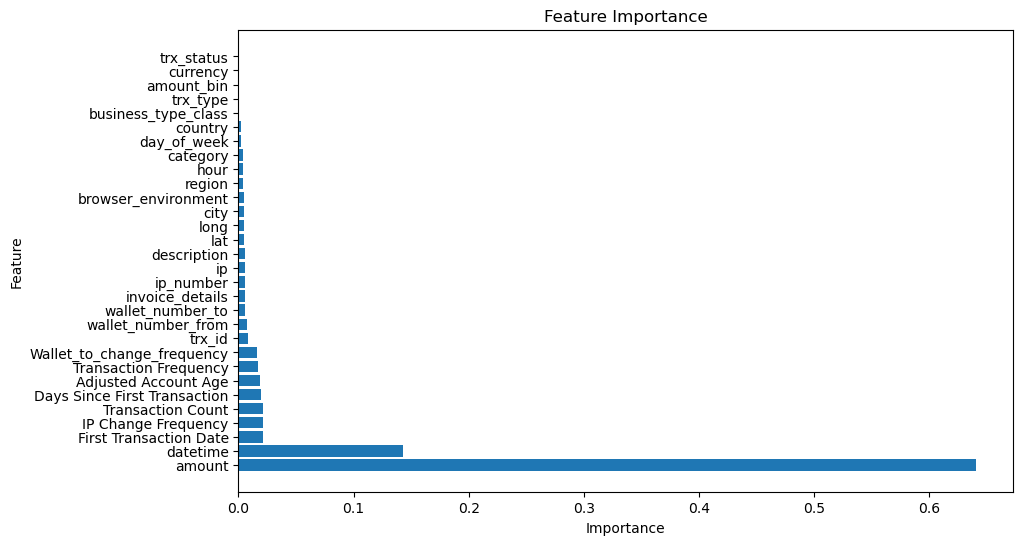

In [4]:
# Exclude time-related columns
features = final_df.drop(['date', 'time'], axis=1)

# Get non-numeric columns
non_numeric_cols = features.select_dtypes(include=['object']).columns

# Use label coding
label_encoder = LabelEncoder()
for col in non_numeric_cols:
    features[col] = label_encoder.fit_transform(features[col])

# Acquisition of features and target variables
X = features.drop('flagged', axis=1)
y = features['flagged']

# Create a random forest classifier model
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X, y)

# Access to feature significance
feature_importances = rf_classifier.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))

plt.barh(importance_df['Feature'], importance_df['Importance'])

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.show()

In [10]:
# Convert 'datetime' and 'First Transaction Date'columns to datetime type
final_df['datetime'] = pd.to_datetime(final_df['datetime'])
final_df['First Transaction Date'] = pd.to_datetime(final_df['First Transaction Date'])

# Convert datetime to Unix timestamps (in seconds)
final_df['datetime_unix'] = final_df['datetime'].astype(int) // 10**9  # Convert to seconds
final_df['first_transaction_unix'] = final_df['First Transaction Date'].astype(int) // 10**9  # Convert to seconds

In [14]:
# Selection of features
selected_features = ['amount','datetime_unix','first_transaction_unix', 'Wallet_to_change_frequency', 'Transaction Count',
                     'IP Change Frequency','Adjusted Account Age','Transaction Frequency']

# Extract selected features
X = final_df[selected_features]

# Define scaler
scaler = StandardScaler()

# Apply Robust PCA modeling with best hyperparameters
rpca = PCA(n_components=2, svd_solver='full')
principal_components = rpca.fit_transform(X)

# Calculate the squared reconstruction error
reconstruction_errors = np.square(X - rpca.inverse_transform(principal_components)).sum(axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95) 

# Label data points as outliers if their reconstruction error is above the threshold
is_outlier = reconstruction_errors > threshold

# Output the counts of outliers and inliers
num_outliers = np.sum(is_outlier)
num_inliers = X.shape[0] - num_outliers
print("Number of outliers:", num_outliers)
print("Number of inliers:", num_inliers)

# Generate classification report
y_true = final_df['flagged']
y_pred = is_outlier.astype(int)
report = classification_report(y_true, y_pred)
print(report)

Number of outliers: 24277
Number of inliers: 461254
              precision    recall  f1-score   support

       False       0.76      1.00      0.86    350352
        True       1.00      0.18      0.30    135179

    accuracy                           0.77    485531
   macro avg       0.88      0.59      0.58    485531
weighted avg       0.83      0.77      0.71    485531



AUC Score: 0.45134453093191035


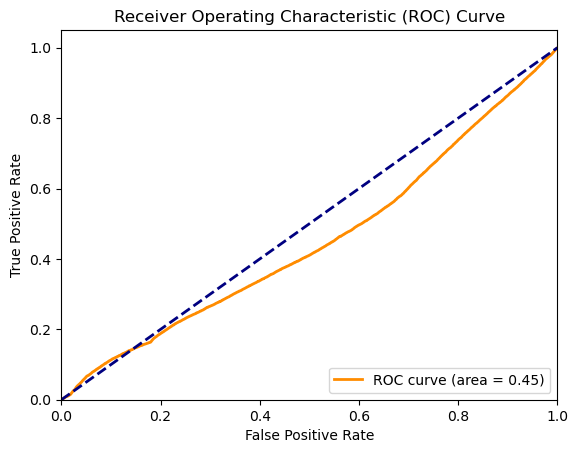

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, final_df['flagged'], test_size=0.2, random_state=42)

# Apply Robust PCA modeling with best hyperparameters
rpca = PCA(n_components=6, svd_solver='full')
principal_components = rpca.fit_transform(X_train)

# Calculate the squared reconstruction error for test set
reconstruction_errors_test = np.square(X_test - rpca.inverse_transform(rpca.transform(X_test))).sum(axis=1)

# Calculate AUC
auc_score = roc_auc_score(y_test, reconstruction_errors_test)

print("AUC Score:", auc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors_test)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()